In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in census csv
census_data = pd.read_csv("../00_input/census_data.csv", dtype={'ZCTA': 'str'})
census_data.head()

,median_household_income,population,median_age,per_capita_income,poverty_count,unemployment_count,ZCTA
0,13092.0,17242.0,40.5,6999.0,10772.0,2316.0,00601
1,16358.0,38442.0,42.3,9277.0,19611.0,1927.0,00602
2,16603.0,48814.0,41.1,11307.0,24337.0,3124.0,00603
3,12832.0,6437.0,43.3,5943.0,4163.0,230.0,00606
4,19309.0,27073.0,42.1,10220.0,11724.0,1290.0,00610


## 1. Column Reordering 

In [3]:
# Reorder the columns 
census_data = census_data[["ZCTA", "population", "median_age", "median_household_income", "per_capita_income",
                           "poverty_count", "unemployment_count"]]
census_data.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0
3,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0
4,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0


## EDA
With .info(), we are taking a quick glance at the various data types within the census data frame to get a better idea of how we will handle transformations later on. The schema we have created using SQL categorizes 'Population', 'Poverty Count' and 'Unemployment Count' as integers so we will have to convert these data types once we handle the null values in those respective columns.

Using .isnull() allows us to see the number of NaN values in each column of the data set before we decide how to treat them. 

With .decribe() gives us summary statistics of the data frame. However, many of the values in the Median Age, Median Household Income and Per Capita Income columns are negative, which is inaccurate and signals to us that there may be invalid values in multiple columns of the dataset we have pulled. We would have to apply some filters to identify these values.

In [4]:
# Overview of the census dataframe
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ZCTA                     33120 non-null  object 
 1   population               33120 non-null  float64
 2   median_age               33120 non-null  float64
 3   median_household_income  33085 non-null  float64
 4   per_capita_income        32776 non-null  float64
 5   poverty_count            33085 non-null  float64
 6   unemployment_count       33085 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.8+ MB


In [5]:
# Identifying and counting null values in each column in the data frame  
nan_count = census_data.isnull().sum()
nan_count[nan_count > 0].sort_values(ascending=False)

per_capita_income          344
unemployment_count          35
poverty_count               35
median_household_income     35
dtype: int64

In [6]:
# Summary statistics at first glance
census_data.describe()

,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
count,33120.000000,3.312000e+04,3.308500e+04,3.277600e+04,33085.000000,33085.000000
mean,9851.278865,-1.135262e+07,-4.415424e+07,-6.479207e+06,1382.396917,293.679220
std,14614.856872,8.625416e+07,1.659040e+08,6.555433e+07,2664.579362,518.523009
min,0.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08,0.000000,0.000000
25%,705.000000,3.660000e+01,4.059500e+04,2.200575e+04,74.000000,13.000000
50%,2803.500000,4.170000e+01,5.250000e+04,2.715100e+04,318.000000,68.000000
75%,13378.500000,4.710000e+01,6.691000e+04,3.389500e+04,1418.000000,343.000000
max,122814.000000,9.830000e+01,2.500010e+05,4.612790e+05,35874.000000,9120.000000


## EDA
Obtaining the min values of each variable allows us to get a better understanding on the extreme values we are dealing with and storing them in variables will allows us to filter these values out. It is evident that three columns: Median Household Income, Median Age and Per Capita Income contain the values '-666,666,666.0'.

By using a groupby, we can see how many times this value comes up in those columns: 564 times in median age, 2194 times in Median Household Income and 320 in Per Capita Income. Upon further research, the US Census Bureau has reported various data collection errors in different states and counties (zip codes that match the ones that have these values) in the 2018 datasets. This could potentially be the reason for these extreme values but there is no concerete explanation by the census for them.

Link: https://www.census.gov/programs-surveys/acs/technical-documentation/errata/120.html

In [7]:
# Get min values for each column and store them in variables for filtering
min_income = census_data['median_household_income'].min()
min_pop = census_data['population'].min()
min_age = census_data['median_age'].min()
min_per_capita = census_data['per_capita_income'].min()
min_poverty = census_data['poverty_count'].min()
min_unemp = census_data['unemployment_count'].min()

print(f"The min Median Household Income is {min_income}")
print(f"The min Population is {min_pop}")
print(f"The min Median Age is {min_age}")
print(f"The min Per Capita Income is {min_per_capita}")
print(f"The min Poverty Count is {min_poverty}")
print(f"The min Unemployment Count is {min_unemp}")

The min Median Household Income is -666666666.0
The min Population is 0.0
The min Median Age is -666666666.0
The min Per Capita Income is -666666666.0
The min Poverty Count is 0.0
The min Unemployment Count is 0.0


In [8]:
# How many times does -666,666,666.0 come up in those three columns 
print(census_data.groupby('median_age').size())
print(census_data.groupby('median_household_income').size())
print(census_data.groupby('per_capita_income').size())

median_age
-666666666.0    564
 2.4              1
 3.0              1
 3.7              1
 3.9              1
               ... 
 87.6             1
 87.8             1
 88.0             1
 88.6             1
 98.3             1
Length: 671, dtype: int64
median_household_income
-666666666.0    2194
 2499.0            4
 6271.0            1
 6878.0            1
 7622.0            1
                ... 
 242557.0          1
 242629.0          1
 243311.0          1
 246813.0          1
 250001.0         15
Length: 19796, dtype: int64
per_capita_income
-666666666.0    320
 42.0             1
 527.0            1
 557.0            1
 612.0            1
               ... 
 201010.0         1
 207327.0         1
 207372.0         1
 279429.0         1
 461279.0         1
Length: 21270, dtype: int64


In [9]:
# Check the rows for Median Age that contain -666,666,666.0
df_age = census_data[census_data['median_age'] == min_age]
df_age.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
110,00950,0.0,-666666666.0,-666666666.0,-666666666.0,0.0,0.0
111,00951,0.0,-666666666.0,-666666666.0,-666666666.0,0.0,0.0
167,01066,9.0,-666666666.0,-666666666.0,NaN,0.0,0.0
206,01199,0.0,-666666666.0,-666666666.0,-666666666.0,0.0,0.0
514,02203,25.0,-666666666.0,-666666666.0,NaN,13.0,0.0


## EDA
The next two cells show that when Median Age values are -666,666,666.0, the corresponding values in Median Household Income and Per Capita Income are null values. This means we can drop all the rows where Median Age is equal to -666,666,666.0.

In [10]:
# Check unique values in Median HH Income when Median Age = -666,666,666.0
df_age["median_household_income"].unique()

array([-6.66666666e+08,             nan])

In [11]:
# Check unique values in Per Capita Income when Median Age = -666,666,666.0
df_age["per_capita_income"].unique()

array([-6.66666666e+08,             nan])

## 2. Filter out the rows where Median Age = -666,666,666.0 
564 rows were dropped, leaving us with 32,556 rows in our dataset. 
We have done this as having NaN/invalid values in Median HH Income, Median Age and Per Capita Income reduces the analytical potential/usefulness of the dataset. Very little insight can be drawn from just zcta, population, poverty and unemployment count data. 

In [12]:
# Filter out the rows where Median Age = -666666666.0 
clean_census = census_data[census_data['median_age'] != min_age]
clean_census.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0
3,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0
4,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0


In [13]:
# Count all null values per column to see what we have left 
nan_count = clean_census.isnull().sum()
nan_count[nan_count > 0].sort_values(ascending=False)

per_capita_income          100
unemployment_count          31
poverty_count               31
median_household_income     31
dtype: int64

In [14]:
# Identify the last 50 rows to find NaN values located at the end of the dataset 
clean_census.tail(50)

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
33064,99826,416.0,52.4,80000.0,43278.0,7.0,22.0
33065,99827,2565.0,45.2,63882.0,33387.0,230.0,52.0
33066,99829,800.0,46.4,63750.0,27546.0,89.0,65.0
33067,99830,595.0,37.5,53625.0,18520.0,53.0,52.0
33068,99832,124.0,56.8,93125.0,45913.0,8.0,8.0
33069,99833,3255.0,41.0,66907.0,33227.0,267.0,70.0
33070,99835,8738.0,38.8,71534.0,38423.0,639.0,216.0
33071,99836,97.0,40.1,69375.0,24227.0,9.0,3.0
33072,99840,1061.0,38.5,72237.0,39842.0,56.0,51.0
33073,99841,155.0,57.8,55833.0,31441.0,6.0,0.0


## 3. Drop the 31 rows with 4 NaN values  
31 rows were dropped, leaving us with 32,525 rows in our dataset. 
For the same reason as before, having those 4 NaN values in those columns reduces the value of this dataset and limits the amount of insights that can be drawn. 

In [15]:
# Drop the 31 rows with 4 NaN values in each row 
clean_census = clean_census.dropna(subset=['median_household_income'])
clean_census.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0
3,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0
4,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0


In [16]:
# Checking if the null values were dropped (there should be 69 null values in Per Capita Income left)
nan_count = clean_census.isnull().sum()
nan_count[nan_count > 0].sort_values(ascending=False)

per_capita_income    69
dtype: int64

## EDA 
We are interested in inspecting the Median Household Income column when Per Capita Income values are null. We observe that there are only three unique, reasonable values and 66, inaccurate values (-666,666,666.0). To further transform this dataset, we we will drop these 66 rows. 

In [17]:
# Filter down to rows that have null values in the Per Capita Income column 
df_per_cap_inc = clean_census.loc[clean_census['per_capita_income'].isnull()]

In [18]:
# Unique values in Median HH Income when Per Capita Income is NaN 
df_per_cap_inc["median_household_income"].unique()

array([-6.66666666e+08,  2.32190000e+04,  3.93640000e+04,  2.49900000e+03])

## 4. Drop the 66 rows with -666,666,666.0 and NaN values  

In [19]:
# Drop ONLY the rows where med HH income = -666,666,666.0 AND per capita income = NaN (66 rows should be dropped)
clean_census = clean_census.loc[~((clean_census['median_household_income'] == min_income) & 
                            (clean_census['per_capita_income'].isnull())),:]
clean_census.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0
3,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0
4,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0


In [20]:
# Checking if the null values were dropped (there should be 69 null values in Per Capita Income left)
nan_count = clean_census.isnull().sum()
nan_count[nan_count > 0].sort_values(ascending=False)

per_capita_income    3
dtype: int64

## EDA
Now that we have dealt with the NaN values in our dataset, we are interested in inspecting the -666,666,666.0 values in the Median Household Income column. The 1568 rows with the values in "Median Household Income" column of -666666666.0 seem to have the other columns with normal-looking values. Hence, we'll only change these -666666666.0 values into NaN to keep the data for further analysis.

In [21]:
# Checking the rows that have -666666666.0 as Median HH income 
df_HH_income = clean_census[clean_census['median_household_income'] == min_income]
df_HH_income.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
42,00694,69.0,73.6,-666666666.0,6880.0,24.0,0.0
86,00786,348.0,64.0,-666666666.0,14278.0,46.0,0.0
107,00934,79.0,32.8,-666666666.0,16956.0,0.0,26.0
108,00936,812.0,77.3,-666666666.0,7132.0,0.0,0.0
117,00960,2221.0,32.8,-666666666.0,3069.0,23.0,6.0


## 5. Replace -666,666,666.0 values to NaN 

In [22]:
#  Change remaining -666666666.0 values in Median HH Income to NaN 
clean_census = clean_census.replace(min_income, np.nan)

In [23]:
# Counting all null values per column after -666666666.0 is changed to NaN 
nan_count = clean_census.isnull().sum()
nan_count[nan_count > 0].sort_values(ascending=False)

median_household_income    1568
per_capita_income             3
dtype: int64

In [24]:
# Reset the index
clean_census = clean_census.reset_index(drop=True)
clean_census

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0
3,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0
4,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0
...,...,...,...,...,...,...,...
32454,99922,330.0,39.5,34028.0,18213.0,129.0,11.0
32455,99925,927.0,43.6,57375.0,25840.0,172.0,89.0
32456,99926,1635.0,34.5,53409.0,22453.0,235.0,138.0
32457,99927,38.0,55.5,NaN,13658.0,28.0,0.0


In [25]:
# Count the number of unique ZCTAs in the dataframe
len(clean_census['ZCTA'].unique())

32459

## 6. Merging (Outer join) zip to zcta dataframe with the census dataframe
There are two reasons why we are merging the zip-to-zcta dataframe with the census dataframe:
1. To ensure that all of the ZCTAs in our census dataframe have a matching ZCTA in the zip_to_zcta dataframe - otherwise, there will be an error when loading these datasets into our SQL database. 

2. To add all of the remaining ZCTAs present ONLY in the zip_to_zcta table into the census table. (The outer join will enter null values into every column for all the added ZCTAs) This is done to preserve the one-to-many relationship between the census table and the zip_to_zcta table in our schema. 

Recall that:
1. 1 ZCTA (Zip Code Tabulation Area) can have multiple Zip Codes
2. 1 ZCTA in the Census table can appear multiple times in the zip_to_zcta junction table --> THUS the one-to-many relationship 

In [26]:
 # Read in census csv
zip_to_zcta_df = pd.read_csv("../02_transform_zip_zcta/zcta.csv", dtype ='str')
zip_to_zcta_df.head()

,zip_code,ZCTA
0,00501,11742
1,00544,11742
2,00601,00601
3,00602,00602
4,00603,00603


In [27]:
# Merge the zip_to_zcta df with the census data frame using an outer join 
zcta_census = pd.merge(clean_census, zip_to_zcta_df, how="outer", on="ZCTA")
zcta_census.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count,zip_code
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0,00601
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0,00602
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00603
3,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00604
4,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00605


## EDA 
As you can see, there are 41,099 non-null ZCTA and 41,098 non-null zip_code. This means there is one ZCTA in the census table without a matching ZCTA in the zip_to_zcta table. We will drop this row as we will not be able to draw insights from it.

In [28]:
# Overview of the merged dataframe 
zcta_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41099 entries, 0 to 41098
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ZCTA                     41099 non-null  object 
 1   population               40297 non-null  float64
 2   median_age               40297 non-null  float64
 3   median_household_income  38669 non-null  float64
 4   per_capita_income        40294 non-null  float64
 5   poverty_count            40297 non-null  float64
 6   unemployment_count       40297 non-null  float64
 7   zip_code                 41098 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.8+ MB


In [29]:
# Identify specific row that has NaN in the zipcode column 
zcta_census[zcta_census["zip_code"].isnull()]

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count,zip_code
38108,95314,95.0,19.4,NaN,8711.0,0.0,0.0,NaN


## 7. Filter row 38108 out of the clean_census dataframe

In [30]:
# Identify the ZCTA to remove from clean_census
zcta_to_remove = zcta_census[zcta_census["zip_code"].isnull()]["ZCTA"].to_list()
zcta_to_remove

['95314']

In [35]:
# Remove the above ZCTA from the census table and save newly merged dataframe 
final_census = zcta_census[~zcta_census["ZCTA"].isin(zcta_to_remove)].copy()
final_census

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count,zip_code
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0,00601
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0,00602
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00603
3,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00604
4,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00605
...,...,...,...,...,...,...,...,...
41094,54010,NaN,NaN,NaN,NaN,NaN,NaN,54010
41095,63464,NaN,NaN,NaN,NaN,NaN,NaN,63464
41096,83601,NaN,NaN,NaN,NaN,NaN,NaN,83601
41097,96799,NaN,NaN,NaN,NaN,NaN,NaN,96799


## 8. Drop the duplicate ZCTAs and zip code column in new dataframe
Before the merge, there were 32,459 unique ZCTAs in the clean_census table. Now there are 41,098 ZCTAs in the final_census table. This means that the outer join resulted in duplicates in the ZCTA column. We will need to drop these duplicates to ensure uniqueness for the primary key. 

We will also drop the zip code column as we have established a junction table that will link the ZCTAs in our census table to the ZCTAs and corresponding zip codes in the zip_to_zcta junction table. 

In [36]:
# Overview of the final census dataframe after the merge
final_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41098 entries, 0 to 41098
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ZCTA                     41098 non-null  object 
 1   population               40296 non-null  float64
 2   median_age               40296 non-null  float64
 3   median_household_income  38669 non-null  float64
 4   per_capita_income        40293 non-null  float64
 5   poverty_count            40296 non-null  float64
 6   unemployment_count       40296 non-null  float64
 7   zip_code                 41098 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.8+ MB


In [39]:
# Drop ZCTA duplicates 
final_census.drop_duplicates(subset = "ZCTA", keep = "first", inplace = True)
final_census.head()

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count,zip_code
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0,00601
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0,00602
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0,00603
5,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0,00606
6,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0,00610


In [40]:
# Overview of the final census table after dropping the duplicates 
final_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33166 entries, 0 to 41098
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ZCTA                     33166 non-null  object 
 1   population               32458 non-null  float64
 2   median_age               32458 non-null  float64
 3   median_household_income  30891 non-null  float64
 4   per_capita_income        32455 non-null  float64
 5   poverty_count            32458 non-null  float64
 6   unemployment_count       32458 non-null  float64
 7   zip_code                 33166 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.3+ MB


In [41]:
# Drop the zip_code column 
final_census = final_census.drop(columns = ['zip_code'])
final_census

,ZCTA,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
0,00601,17242.0,40.5,13092.0,6999.0,10772.0,2316.0
1,00602,38442.0,42.3,16358.0,9277.0,19611.0,1927.0
2,00603,48814.0,41.1,16603.0,11307.0,24337.0,3124.0
5,00606,6437.0,43.3,12832.0,5943.0,4163.0,230.0
6,00610,27073.0,42.1,19309.0,10220.0,11724.0,1290.0
...,...,...,...,...,...,...,...
41094,54010,NaN,NaN,NaN,NaN,NaN,NaN
41095,63464,NaN,NaN,NaN,NaN,NaN,NaN
41096,83601,NaN,NaN,NaN,NaN,NaN,NaN
41097,96799,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Counting the null values after the merge 
nan_count = final_census.isnull().sum()
nan_count[nan_count > 0].sort_values(ascending=False)

median_household_income    2275
per_capita_income           711
unemployment_count          708
poverty_count               708
median_age                  708
population                  708
dtype: int64

In [43]:
# Use a .describe() to get summary stats of the clean dataset 
summary_stat = round(final_census.describe(),2)
summary_stat

,population,median_age,median_household_income,per_capita_income,poverty_count,unemployment_count
count,32458.00,32458.00,30891.00,32455.00,32458.00,32458.00
mean,10050.24,42.50,59031.43,29913.58,1409.02,299.34
std,14695.46,8.93,25240.24,13870.78,2683.23,521.89
min,5.00,3.70,2499.00,42.00,0.00,0.00
25%,776.00,36.90,42981.00,22191.00,81.00,14.00
50%,2960.00,41.90,53958.00,27250.00,335.00,72.00
75%,13771.00,47.30,68333.00,33996.00,1460.00,354.00
max,122814.00,98.30,250001.00,461279.00,35874.00,9120.00


In [44]:
# Export the census data to csv to load to database
final_census.to_csv('clean_census.csv', index=False)

## Plots 
We are going to look at different plots that map out relationships between different socio-eocnomic measures and outliers in the dataset 

In [45]:
# Store columns in variables 
med_age = final_census['median_age']
med_inc = final_census['median_household_income']
pop = final_census['population']
per_inc = final_census['per_capita_income']
pov_count = final_census['poverty_count']
unemp_count = final_census['unemployment_count']

## Scatter Plots 
The scatter plots below map the relationships between various variables in the census dataset

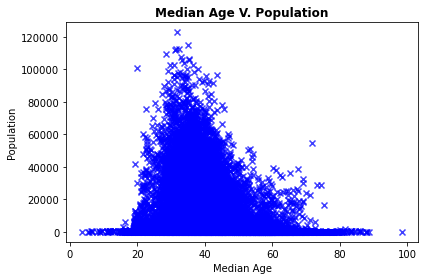

In [46]:
# Generate scatter plot - Population V Median Age
plt.scatter(med_age, pop, marker="x", facecolors="blue", alpha=0.75)
plt.xlabel("Median Age")
plt.ylabel("Population")
plt.title("Median Age V. Population", weight="bold")
plt.tight_layout()

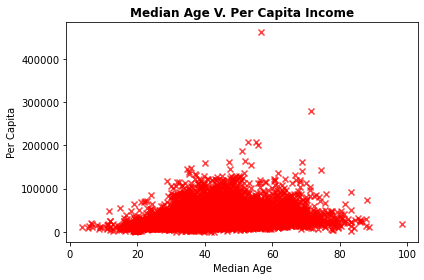

In [47]:
# Generate scatter plot - Median Age V Median HH Income 
plt.scatter(med_age, per_inc, marker="x", facecolors="red", alpha=0.75)
plt.xlabel("Median Age")
plt.ylabel("Per Capita")
plt.title("Median Age V. Per Capita Income", weight="bold")
plt.tight_layout()

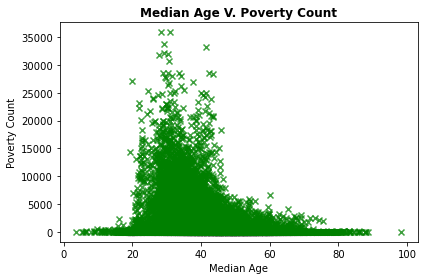

In [48]:
# Generate scatter plot - Median Age V Poverty Count 
plt.scatter(med_age, pov_count, marker="x", facecolors="green", alpha=0.75)
plt.xlabel("Median Age")
plt.ylabel("Poverty Count")
plt.title("Median Age V. Poverty Count", weight="bold")
plt.tight_layout()

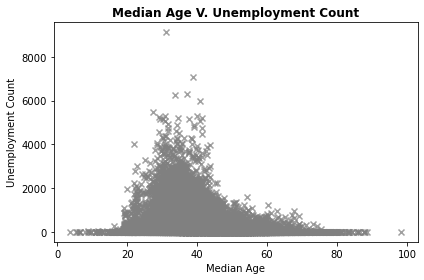

In [49]:
# Generate scatter plot - Median Age V Unemployment Count
plt.scatter(med_age, unemp_count, marker="x", facecolors="grey", alpha=0.75)
plt.xlabel("Median Age")
plt.ylabel("Unemployment Count")
plt.title("Median Age V. Unemployment Count", weight="bold")
plt.tight_layout()